In [1]:
!pip install pennylane

Quantum Mechanics (QM) is a fundamental theory to describe the behavior of matter and energy at microscopic scales. Unfortunately, QM is intrinsically an undeterministic theory, that is, in most cases, equal incomes are referred to as different outcomes. The ability to simulate and predict the dynamics of the outcomes statistics is crucial for various applications.

The main equation that governs QM is the Schrödinger equation that describes the time evolution of the quantum states and, with that, the time evolution for the outcomes statistics. Several methods have been developed to solve the Schrödinger equation to study the dynamics of different quantum systems but, they often encounter challenges when dealing with complex or many-body systems.

Recently, there has been a new tool based on Artificial intelligence to simulate mathematical functions and, with that, a solution for different PDEs. Applications for Physics-Informed Neural Networks (PINNs) combined with the Heisenberg equation (a variant of the Schrödinger equation) represent a new way to study the dynamics of quantum systems. Suppling a neural network with quantum data provided by a quantum computer (a simulation made with Pennylane for this case) is enough to describe accurately the outcomes of the quantum system.

The system that we use for our project is referred to D-wave system [1], that is, a Hamiltonian given by
\begin{equation}
    H = \frac{\hbar}{2} \left\{ J_1 (\sigma_0 \otimes \sigma_x + \sigma_x \otimes \sigma_0) + J_2 (\sigma_0 \otimes \sigma_z + \sigma_z \otimes \sigma_0) + J_3 \sigma_z \otimes \sigma_z \right\}.
\end{equation}

In conventional superconductors, the pairing of electrons is described by a symmetric order parameter, meaning that it has the same magnitude in all directions in momentum space. However, in d-wave superconductors, the pairing occurs with a momentum-dependent order parameter that changes sign as a function of the momentum direction. Specifically, the order parameter has the form of a d-wave (quadrupole) symmetry, which means that it changes sign under a 90-degree rotation in the momentum space.

The d-wave symmetry arises due to the underlying physics of the system, such as the presence of strong electron-electron interactions in certain materials, like cuprate high-temperature superconductors. These materials exhibit unconventional properties, including anisotropic superconducting gaps, which give rise to unique phenomena that distinguish them from conventional superconductors.

Understanding and characterizing d-wave superconductivity is of significant interest in condensed matter physics, as it provides insights into the mechanisms driving superconductivity in these unconventional materials. Moreover, d-wave superconductors have potential applications in various technologies, such as quantum computing and high-sensitivity detectors, due to their unique properties.

To interact with the system, a measurement process describe different expectation values, that is, there exists 15 different observables to use described as a combination
of the Pauli matrices. We define an observable $\mathcal{O}_{ij} := \sigma_i \otimes \sigma_j$, with $i,j = 0,1,2,3$. Now, the expectation value related for an observable satisfies the Heisenberg equation, that is
\begin{equation}
    \frac{\mathrm{d}}{\mathrm{d}t} \langle \mathcal{O}_{ij} \rangle = \left\langle \frac{i}{\hbar} [H, \mathcal{O}_{ij}] \right\rangle.
\end{equation}

The following steps consists in implement the Hamiltonian to simulate an experimental data with Pennylane and, then, use that data (arround with the Heisenberg equation)
to train our neural network. Our final result is a neural network that estimate accurately every expectation value at time $t$.

[1] https://doi.org/10.1016/j.photonics.2017.02.001

In [2]:
# The libraries that we are going to use for our project is Torch to develop the Neural Network, Pennylane to simulate quantum data and Matplotlib to show our results.

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane.templates import ApproxTimeEvolution

The first step consists in generate the data to train our Neural Network (NN). The parameters used are $J_1 = -0.1$, $J_2 = -0.2$ and $J_3 = -0.15$.

(feel free to choose different parameters of your choice)

In [3]:
J1  = -0.1
J2  = -0.2
J3  = -0.15
H   = qml.Hamiltonian([J1, J1, J2, J2, J3],
  [qml.PauliX(0), qml.PauliX(1), qml.PauliZ(0), qml.PauliZ(1),qml.PauliZ(0) @ qml.PauliZ(1)]
                    )
print(H)

  (-0.2) [Z0]
+ (-0.2) [Z1]
+ (-0.1) [X0]
+ (-0.1) [X1]
+ (-0.15) [Z0 Z1]


After we define the Hamiltonian of the system, we simulate the data using Pennylane. There are 15 expectation values that must be simulated, and we do it for N = 30 different times.

In [4]:
dev         = qml.device('default.qubit', wires=2)
n           = 40                                                          # The number of Trotter steps used when approximating the time-evolution operator
@qml.qnode(dev)

def circuit(time):
    qml.templates.ApproxTimeEvolution(H, time, n)                       # This function is made to measure the system using the 15 combinations of Pauli matrices.
    expectation_values = [                                              # The return of this function is a Pennylane tensor with the 15 expectation values at time t
        qml.expval(qml.Identity(0) @ qml.PauliX(1)),
        qml.expval(qml.Identity(0) @ qml.PauliY(1)),
        qml.expval(qml.Identity(0) @ qml.PauliZ(1)),
        qml.expval(qml.PauliX(0) @ qml.Identity(1)),
        qml.expval(qml.PauliX(0) @ qml.PauliX(1)),
        qml.expval(qml.PauliX(0) @ qml.PauliY(1)),
        qml.expval(qml.PauliX(0) @ qml.PauliZ(1)),
        qml.expval(qml.PauliY(0) @ qml.Identity(1)),
        qml.expval(qml.PauliY(0) @ qml.PauliX(1)),
        qml.expval(qml.PauliY(0) @ qml.PauliY(1)),
        qml.expval(qml.PauliY(0) @ qml.PauliZ(1)),
        qml.expval(qml.PauliZ(0) @ qml.Identity(1)),
        qml.expval(qml.PauliZ(0) @ qml.PauliX(1)),
        qml.expval(qml.PauliZ(0) @ qml.PauliY(1)),
        qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))
    ]
    return expectation_values

def exp_val_sim(time, format):                                                  # To use that data we must change the format to use it with Torch, to that, we choose
    A = circuit(time)                                                           # two different ways to represent the data. The first one, as a torch tensor and the
    if format == 0:                                                             # second one, as a numpy array.
        A = torch.Tensor([A[i].numpy() for i in range(len(A))])
        return A
    elif format == 1:
        A = np.array([A[i].numpy() for i in range(len(A))])
        return A
    else:
        print('Insert 0 or 1')

N           = 30                                                                # Number of data to train our network
t_obs       = np.linspace(0,40,N)
exp_values  = exp_val_sim(t_obs[0], 0)

for i in range(1, len(t_obs)):
    exp_values = torch.cat((exp_values, exp_val_sim(t_obs[i], 0)))

exp_values  = torch.reshape(exp_values, (len(t_obs), 15))
print(exp_values)                                                              # We print the experimental data that we are going to use to train the NN

tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 1.2415e-01,  2.3068e-01,  9.6502e-01,  1.2415e-01,  6.9806e-03,
          2.3505e-02,  1.2213e-01,  2.3068e-01,  2.3505e-02,  6.1627e-02,
          2.2128e-01,  9.6502e-01,  1.2213e-01,  2.2128e-01,  9.3139e-01],
        [ 3.7190e-01,  2.4923e-01,  8.9163e-01,  3.7190e-01,  8.5748e-02,
          1.2346e-01,  3.4682e-01,  2.4923e-01,  1.2346e-01,  1.1376e-01,
          1.9623e-01,  8.9163e-01,  3.4682e-01,  1.9623e-01,  8.0049e-01],
        [ 5.0899e-01,  6.2322e-02,  8.4210e-01,  5.0899e-01,  2.7087e-01,
          1.7502e-01,  4.2775e-01,  6.2322e-02,  1.7502e-01, -1.4597e-02,
         -3.0702e-02,  8.4210e-01,  4.2775e-01, -3.0702e-02,  7.4373e-01],
        [ 4.3847e-01, -1.3778e-01,  8.4944e-01,  4.3847e-01,  4.0343e-01,
          1.6126e-02,  3.1055e-01,

After we simulate the experimental data to train our NN. We create the NN that we are going to train with that data.

In [5]:
class FNC(nn.Module):
    # Defines the Neural Network that we're going to use for train our solution
    def __init__(self, n_input, n_output, n_hidden, n_layers):
        super().__init__()
        activation      = nn.Tanh
        self.fcs        = nn.Sequential(*[
                            nn.Linear(n_input, n_hidden),
                            activation()
                            ])                                  # Define the input later for our NN
        self.fch        = nn.Sequential(*[
                            nn.Sequential(*[
                                nn.Linear(n_hidden, n_hidden),
                                activation()
                                ])
                            for i in range(n_layers-1)
                            ])                                  # Defines severals hidden layers for our NN
        self.fce        = nn.Linear(n_hidden, n_output)         # Define the output layer the NN

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

Then, we train our NN with the generated data and with the Heisenberg equation. The NN should converge to the correct solution for the PDE.

In [6]:
torch.manual_seed(123)

#  The first step is create the neural network, that is, define the number of layers and the number of neurons
#  for each layer
n_input         = 1
n_output        = 15
n_hidden        = 32
n_layers        = 4

PINN            = FNC(n_input, n_output, n_hidden, n_layers)

# We define the domain for the system, that is, different values of time
t_physics       = torch.linspace(0, 40, 30).view(-1, 1).requires_grad_(True)
t_obs           = torch.linspace(0, 40, N).view(-1, 1).requires_grad_(True)

# We choose the algorithm that we want to optimise the neural network (Adam for this case)
optimiser       = torch.optim.Adam(list(PINN.parameters()), lr=1e-3)
lam             = 1e4                                                                           # A weight for the data loss function
n_train         = 20001                                                                         # The number of traines for our NN
losses          = []

# We run the simulation
for i in range(n_train):
    optimiser.zero_grad()

    exp_val    = PINN(t_physics)
    dexp_val   = []

    for j in range(15):
        dv = torch.autograd.grad(exp_val[:, j], t_physics, torch.ones_like(exp_val[:, j]), create_graph=True)[0]
        dexp_val.append(dv)

    # The following loss fuctions are related with the 15 Heisenbegs equations that we show in the introduction of the project

    loss_01      = torch.mean((dexp_val[0] + J2*exp_val[:, 1] + J3*exp_val[:, 13])**2)
    loss_02      = torch.mean((dexp_val[1] + J1*exp_val[:, 2] - J2*exp_val[:, 0] - J3*exp_val[:, 12])**2)
    loss_03      = torch.mean((dexp_val[2] - J1*exp_val[:, 1])**2)
    loss_10      = torch.mean((dexp_val[3] + J2*exp_val[:, 7] + J3*exp_val[:, 10])**2)
    loss_11      = torch.mean((dexp_val[4] + J2*exp_val[:, 5] + J2*exp_val[:, 8])**2)
    loss_12      = torch.mean((dexp_val[5] + J1*exp_val[:, 6] - J2*exp_val[:, 4] + J2*exp_val[:, 9])**2)
    loss_13      = torch.mean((dexp_val[6] - J1*exp_val[:, 5] + J2*exp_val[:, 10] + J3*exp_val[:, 7])**2)
    loss_20      = torch.mean((dexp_val[7] + J1*exp_val[:, 11] - J2*exp_val[:, 3] - J3*exp_val[:, 6])**2)
    loss_21      = torch.mean((dexp_val[8] + J1*exp_val[:, 12] + J2*exp_val[:, 9] - J2*exp_val[:, 4])**2)
    loss_22      = torch.mean((dexp_val[9] + J1*exp_val[:, 10] + J1*exp_val[:, 13] - J2*exp_val[:, 8] - J2*exp_val[:, 5])**2)
    loss_23      = torch.mean((dexp_val[10] - J1*exp_val[:, 4] + J1*exp_val[:, 14] - J2*exp_val[:, 6] - J3*exp_val[:, 3])**2)
    loss_30      = torch.mean((dexp_val[11] - J1*exp_val[:, 7])**2)
    loss_31      = torch.mean((dexp_val[12] - J1*exp_val[:, 8] + J2*exp_val[:, 13] + J3*exp_val[:, 1])**2)
    loss_32      = torch.mean((dexp_val[13] + J1*exp_val[:, 14] - J1*exp_val[:, 9] - J2*exp_val[:, 12] - J3*exp_val[:, 0])**2)
    loss_33      = torch.mean((dexp_val[14] - J1*exp_val[:, 13] - J1*exp_val[:, 10])**2)

    # Defines the data loss
    exp_val_data = PINN(t_obs)
    loss_data    = torch.mean((exp_val_data - exp_values)**2)

    # Then, we have the total loss for our PINN
    loss        = loss_01 + loss_02 + loss_03 + loss_10 + loss_11 + loss_12 + loss_13 + loss_20 + loss_21 + loss_22 + loss_23 + loss_30 + loss_31 + loss_32 + loss_33 + lam*loss_data
    loss.backward()
    optimiser.step()
    losses.append(loss.item())

An important result of the NN is the loss function. That is, a function that quantifies the difference between the Pennylane simulate data and the outcomes of the NN. In general, for a correct implementation of PINN this function should to converges to zero.

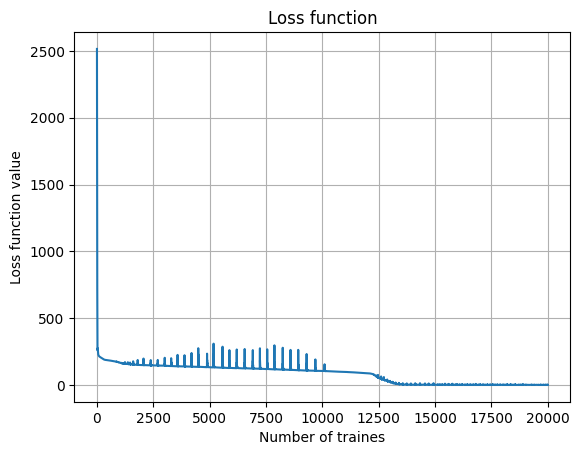

In [7]:
plt.plot(range(n_train), losses)
plt.grid()
plt.xlabel('Number of traines')
plt.ylabel('Loss function value')
plt.title('Loss function')

plt.show()

As we can see, for a high number of traines the loss function converges to zero. That is, the results of the NN match with the data generated by Pennylane.

Moreover, we show the 15 expectation values to compare one-by-one the PINN simulation and the Pennylane simulation.

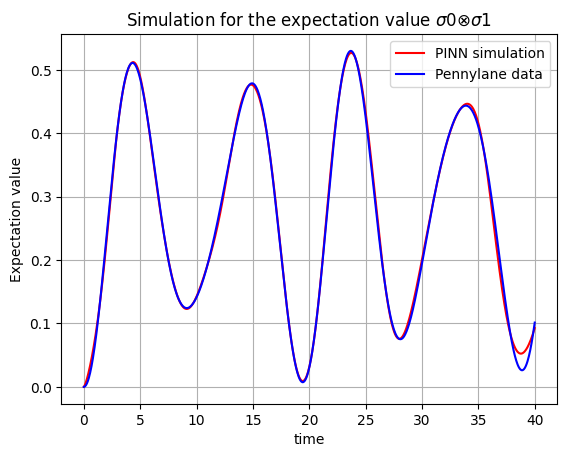

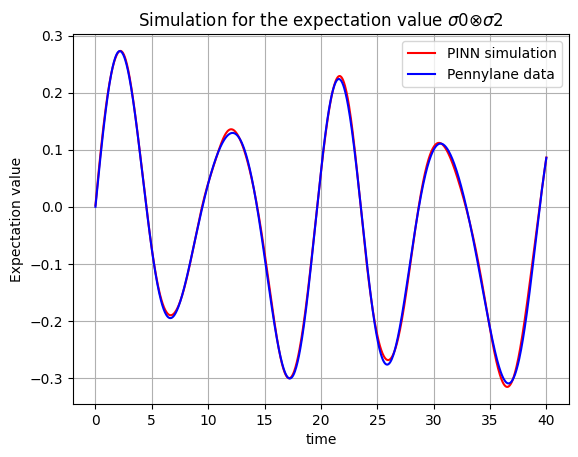

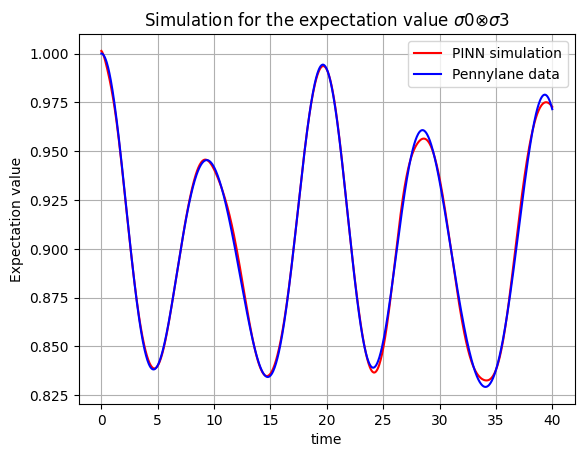

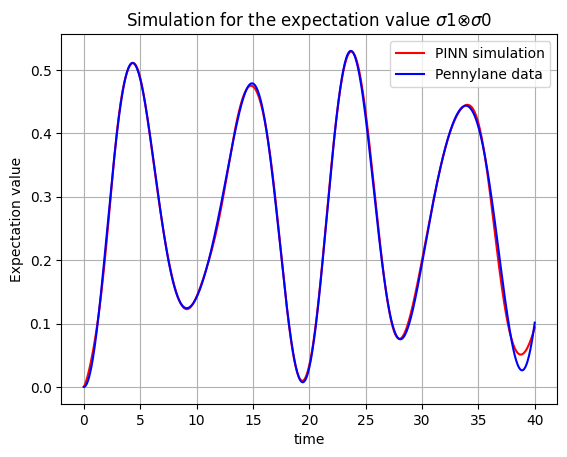

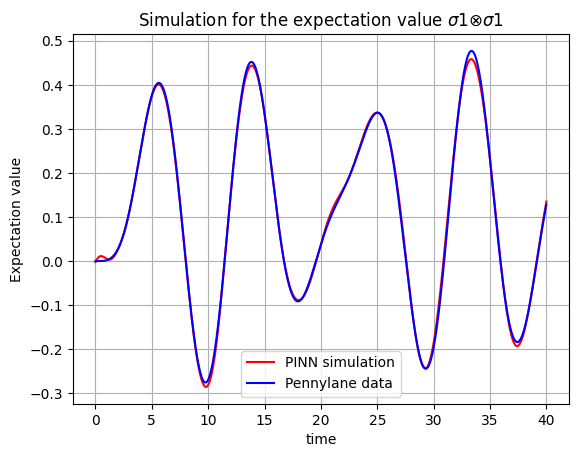

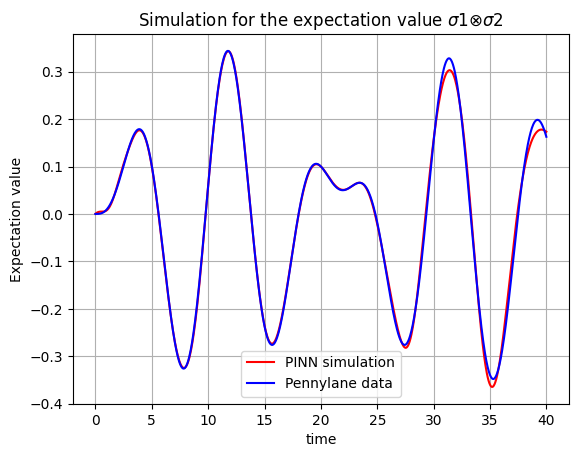

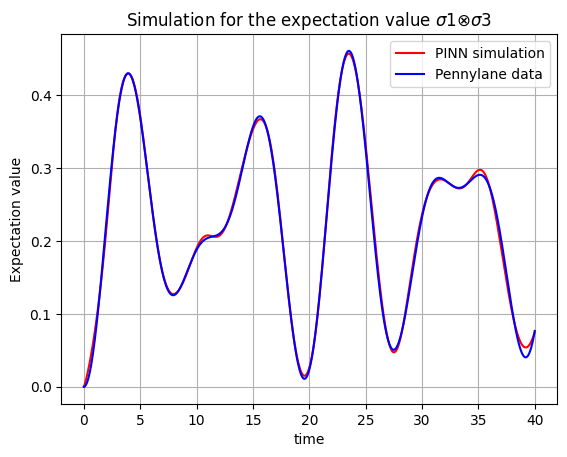

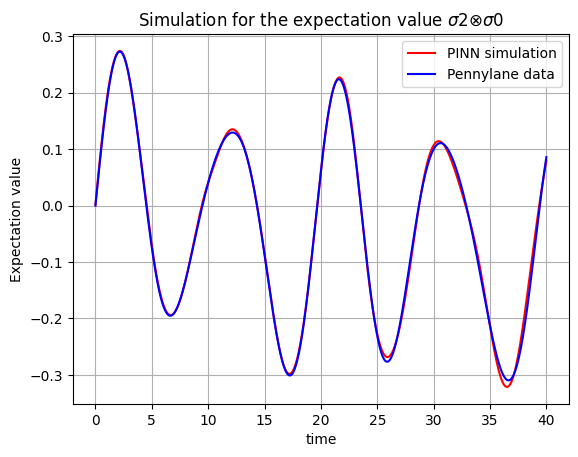

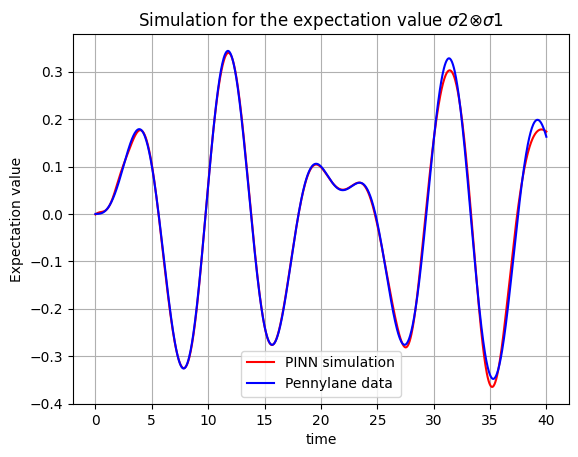

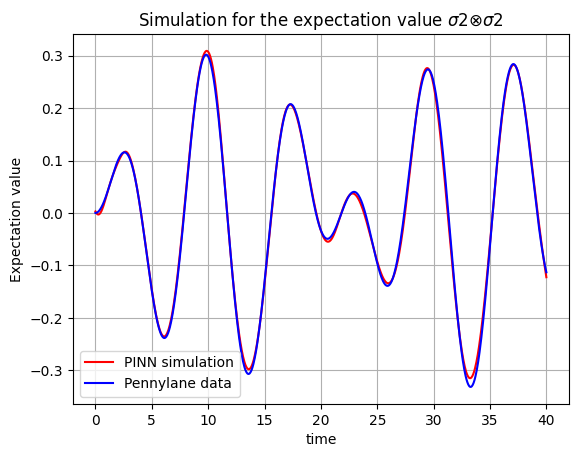

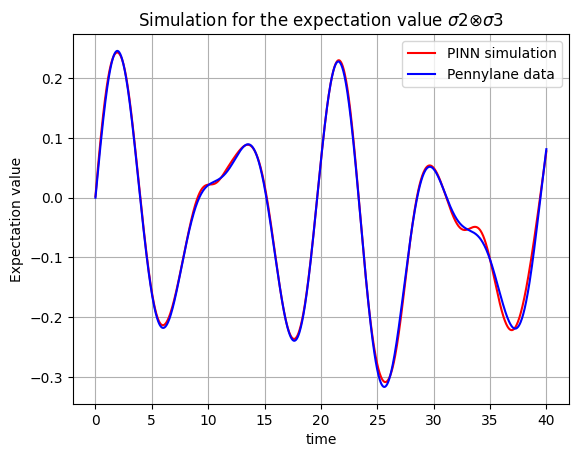

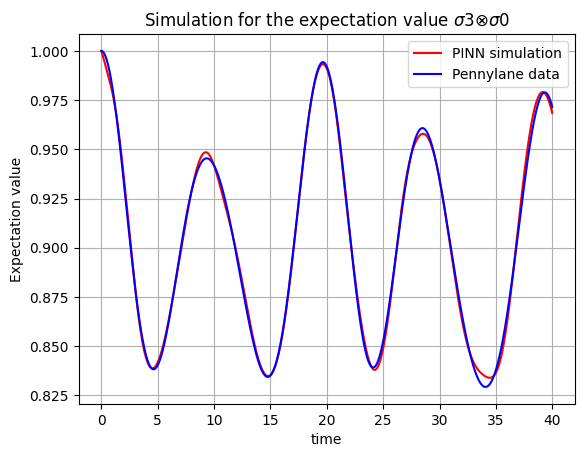

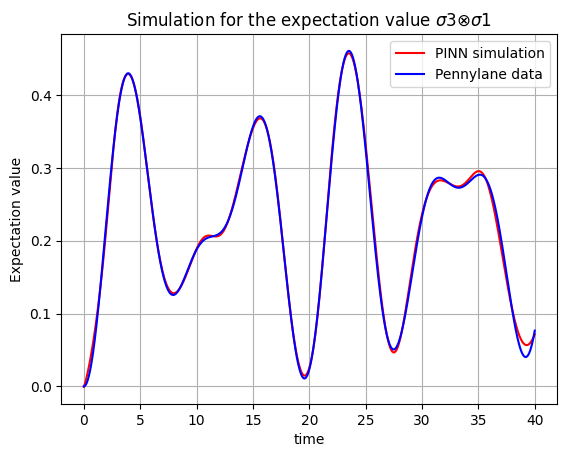

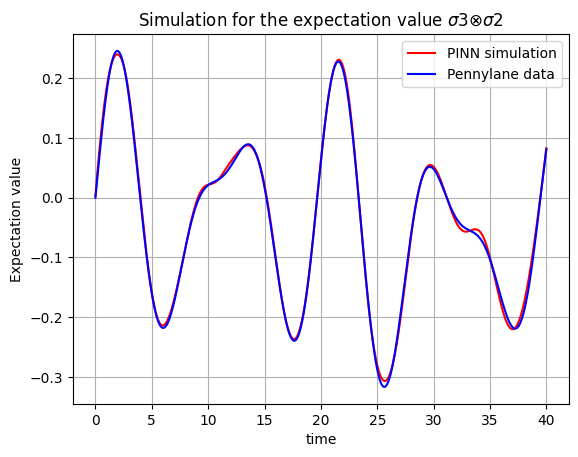

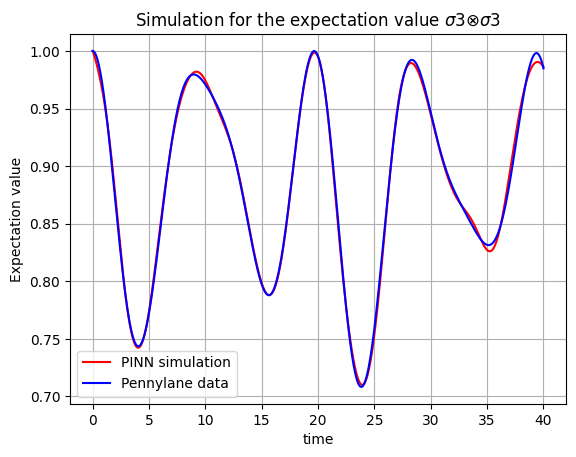

In [9]:
obs_time        = torch.linspace(0, 40, 1000).view(-1, 1).requires_grad_(True)
sim_value       = PINN(obs_time).detach().numpy()

obs_time        = np.linspace(0, 40, 1000)
real_value      = np.array([exp_val_sim(obs_time[i], 1) for i in range(len(obs_time))])

list_expval = [[i, j] for i in range(4) for j in range(4)]
list_expval = list_expval[1:]

for i in range(15):
    plt.plot(obs_time, sim_value[:, i], color='red', label='PINN simulation')
    plt.plot(obs_time, real_value[:, i], color='blue', label='Pennylane data')
    plt.grid()
    plt.legend(loc = 0)
    plt.xlabel('time')
    plt.ylabel('Expectation value')
    plt.title(u'Simulation for the expectation value $\sigma$'+str(list_expval[i][0])+'$\otimes \sigma$'+str(list_expval[i][1]))
    plt.show()

The simulation performed by PINN accurately describes the simulation performed by Pennylane. Better results can be obtained by better choosing the parameters of the neural network (different number of internal layers, or increasing the number of neurons in each internal layer) at the cost of increasing the computing time when training the neural network.

Similar works has been developed, like [2], where the authors use inverse-PINN to find the parameters $J$ of the Hamiltonian.

[2] https://doi.org/10.48550/arXiv.2310.15148